<a href="https://colab.research.google.com/github/KakoozaJerry/test_new_pharma_intelligence/blob/master/pharma_intelligent_systems.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
import warnings
import numpy as np
from numpy import array
import pandas as pd
from pandas import concat
import math
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from statsmodels.tsa.arima_model import ARIMA
from sklearn.model_selection import ParameterGrid

pd.plotting.register_matplotlib_converters()

warnings.filterwarnings("ignore")

import logging
logger = logging.getLogger()
logger.setLevel(logging.CRITICAL)

def mean_absolute_percentage_error(y_true, y_pred): 
    y_true, y_pred = np.array(y_true), np.array(y_pred)
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

In [0]:
!pip install pyramid-arima

     |████████████████████████████████| 604kB 4.9MB/s 


In [2]:
import os
!git clone https://github.com/KakoozaJerry/Excel.git

Cloning into 'Excel'...
remote: Enumerating objects: 34, done.
remote: Counting objects: 100% (34/34), done.
remote: Compressing objects: 100% (32/32), done.
remote: Total 34 (delta 13), reused 0 (delta 0), pack-reused 0
Unpacking objects: 100% (34/34), done.


In [0]:
dfatc_daily = pd.read_excel(os.path.join("Excel","more_sales.xlsx"))

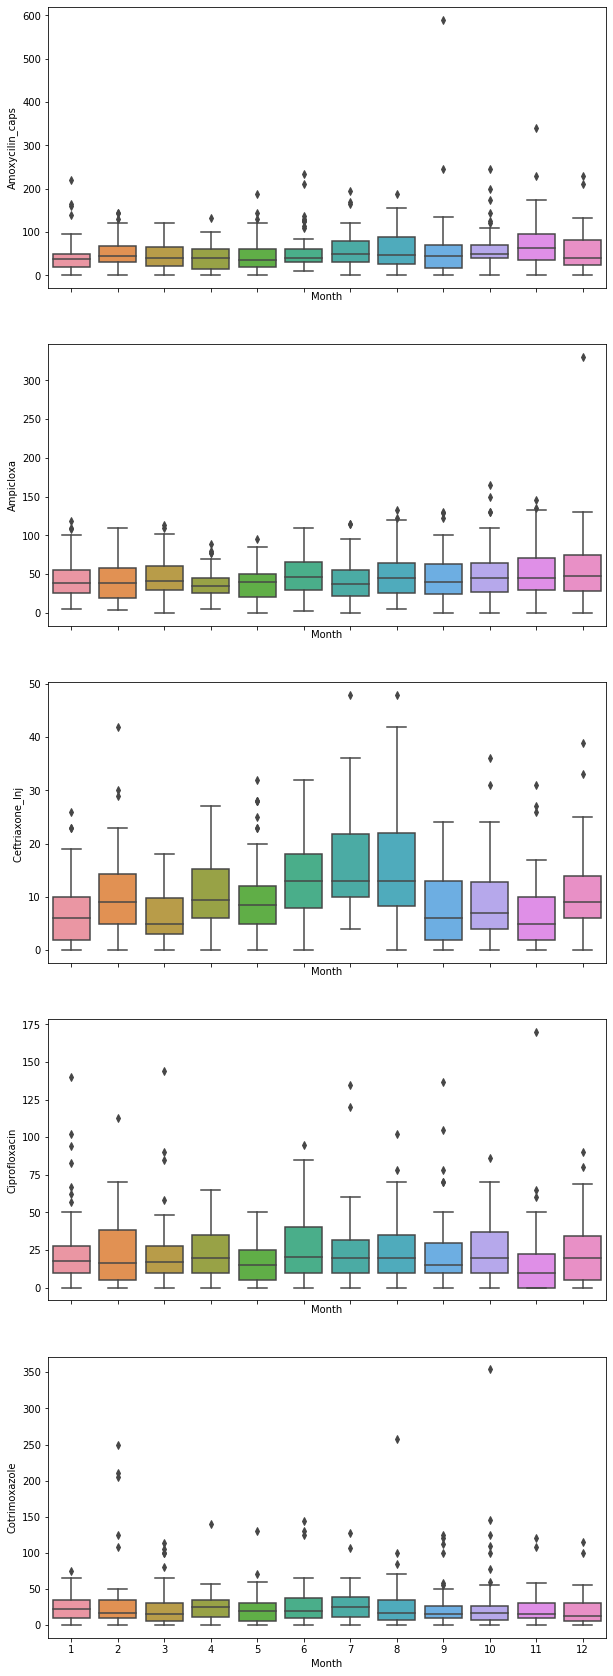

In [0]:
import seaborn as sns

fig, axes = plt.subplots(5, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole'], axes):
    sns.boxplot(data=dfatc_daily, x='Month', y=name, ax=ax)

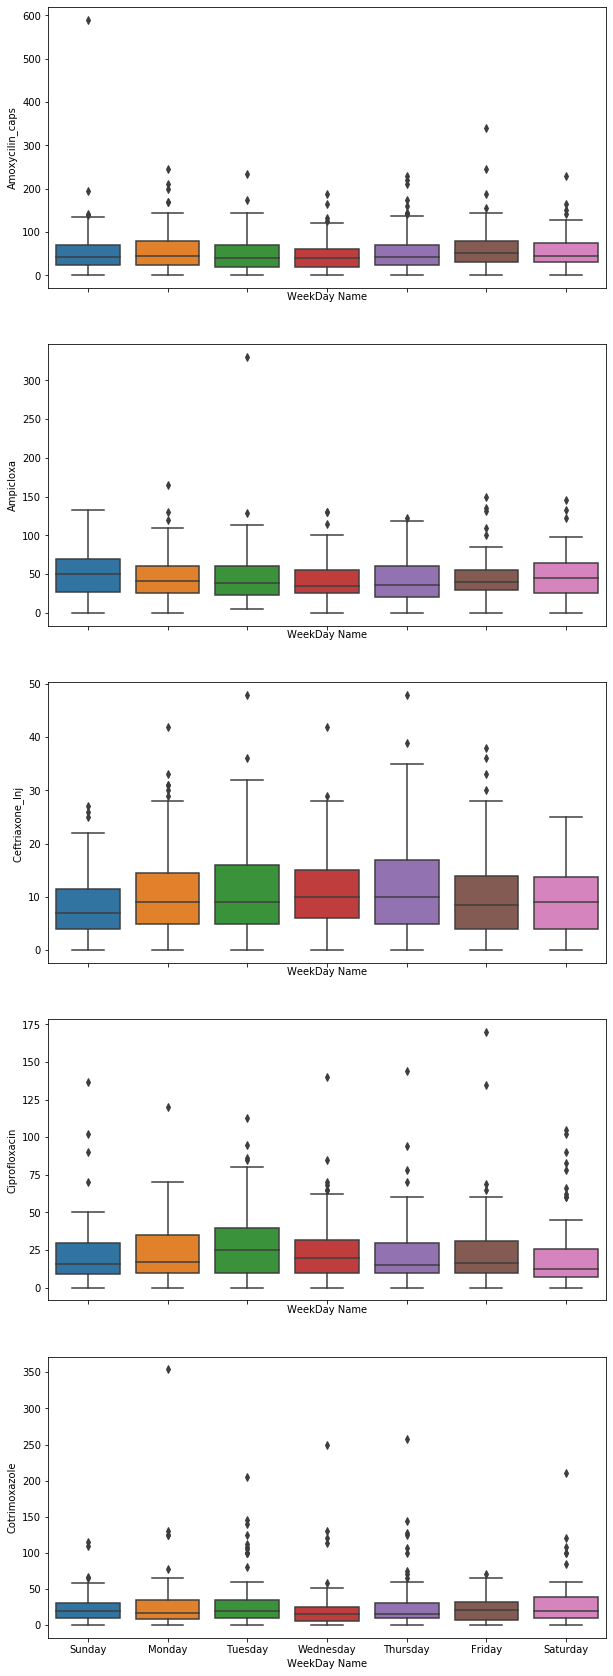

In [0]:
fig, axes = plt.subplots(5, 1, figsize=(10, 30), sharex=True)
for name, ax in zip(['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole'], axes):
    sns.boxplot(data=dfatc_daily, x='WeekDay Name', y=name, ax=ax)

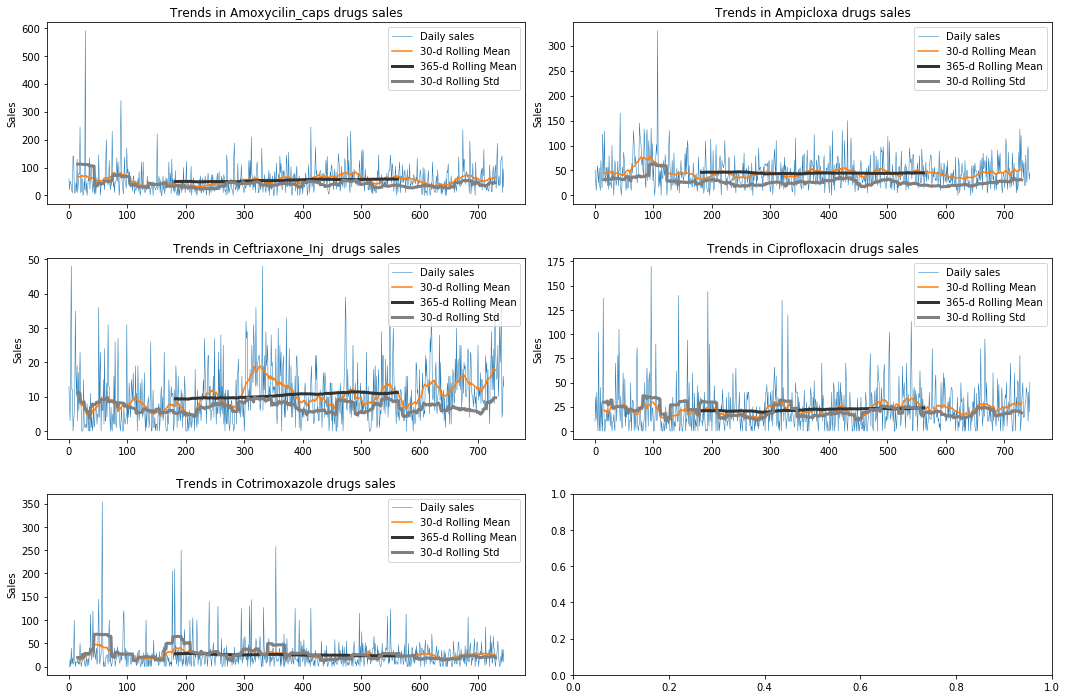

In [0]:
cols_plot = ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']
dfatc_365d = dfatc_daily[cols_plot].rolling(window=365, center=True).mean()
dfatc_30d = dfatc_daily[cols_plot].rolling(30, center=True).mean()
dfatc_std = dfatc_daily[cols_plot].rolling(30, center=True).std()
subplotindex=0
numrows=3
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18, 12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

for x in cols_plot:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ax[rowindex,colindex].plot(dfatc_daily.loc[:,x], linewidth=0.5, label='Daily sales')
    ax[rowindex,colindex].plot(dfatc_30d.loc[:,x], label='30-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_365d.loc[:,x], color='0.2', linewidth=3, label='365-d Rolling Mean')
    ax[rowindex,colindex].plot(dfatc_std.loc[:,x], color='0.5', linewidth=3, label='30-d Rolling Std')
    ax[rowindex,colindex].set_ylabel('Sales')
    ax[rowindex,colindex].legend()
    ax[rowindex,colindex].set_title('Trends in '+x+' drugs sales');   
    subplotindex=subplotindex+1
plt.show()

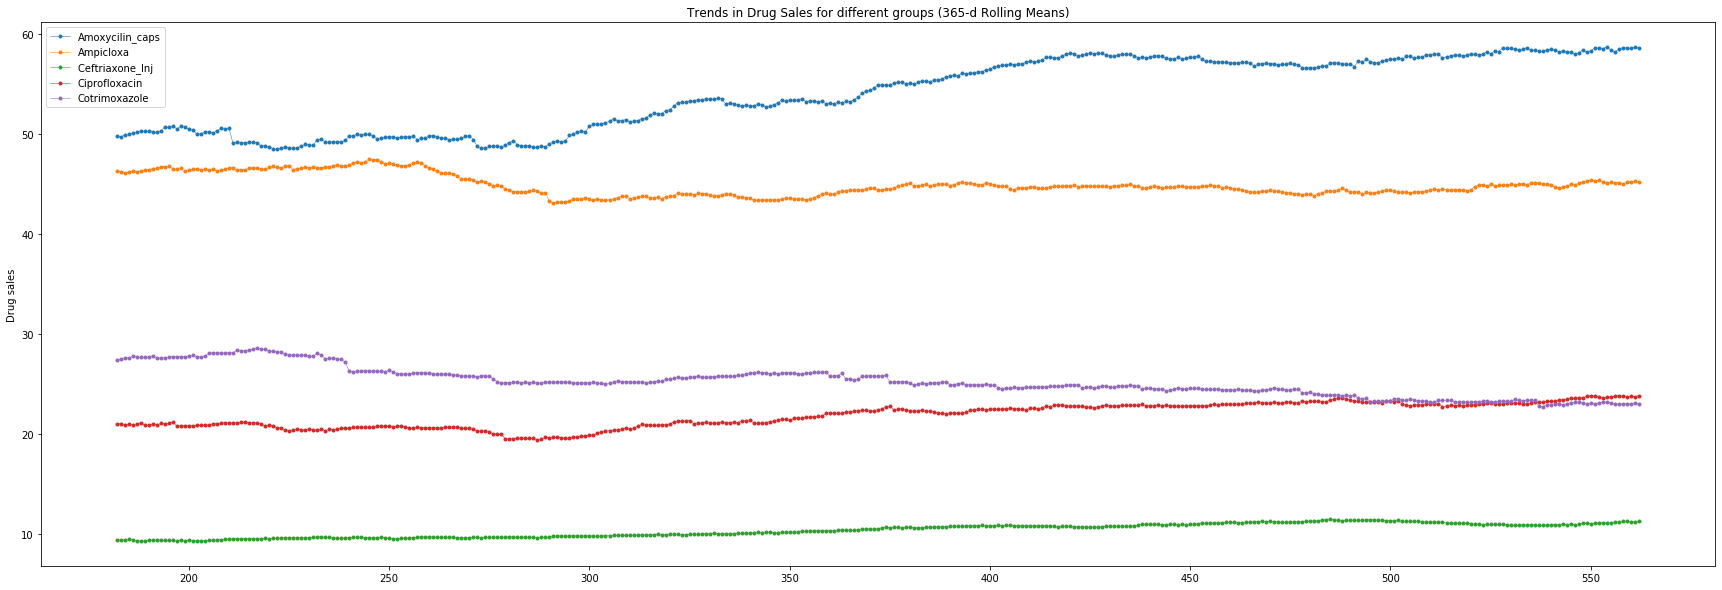

In [0]:
fig, ax = plt.subplots(figsize=(30, 10))
for nm in cols_plot:
    ax.plot(dfatc_365d[nm], label=nm, marker='.', linestyle='-', linewidth=0.5)
    ax.legend()
    ax.set_ylabel('Drug sales')
    ax.set_title('Trends in Drug Sales for different groups (365-d Rolling Means)');

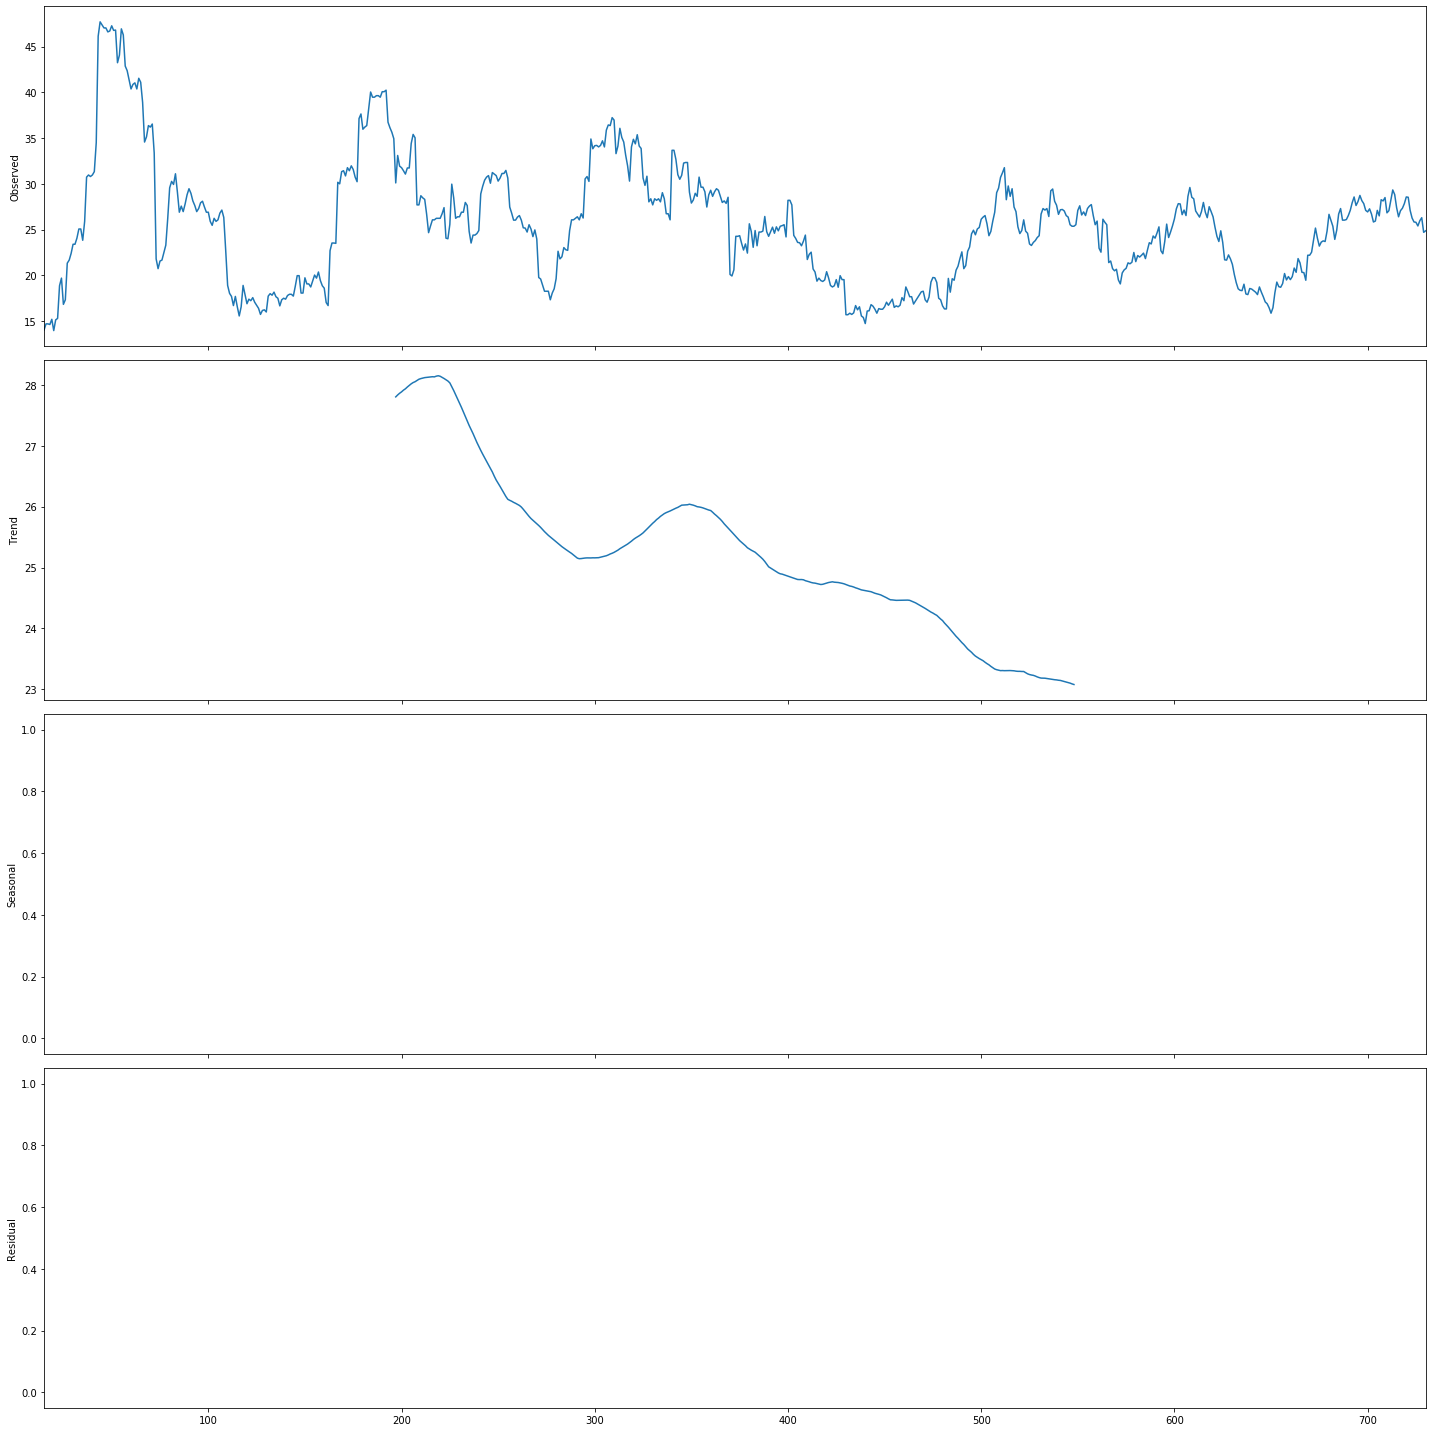

In [0]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(dfatc_daily['Cotrimoxazole'].rolling(30, center=True).mean().dropna(), freq=365, filt=None)
plt.rcParams["figure.figsize"] = (20,20)
result.plot()
plt.show()

In [0]:
df = pd.read_excel(os.path.join("Excel","more_sales.xlsx"))
for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    result = seasonal_decompose(df[x], freq=52, model='additive')
    dfs = pd.concat([result.trend, result.seasonal, result.resid, result.observed], axis=1)
    dfs.columns = ['trend', 'seasonal', 'residuals', 'observed']
    dfs=dfs.dropna()
    res=dfs['residuals'].values
    obs=dfs['observed'].values
    resmean=np.mean(np.abs(res))
    obsmean=np.mean(np.abs(obs))
    perc=resmean*100/obsmean
    print(x+' RESMEAN:'+str(resmean)+', OBSMEAN:'+str(obsmean)+', PERC:'+str(perc)+'%')

Amoxycilin_caps RESMEAN:29.263214651766003, OBSMEAN:53.96392496392497, PERC:54.22736517280487%
Ampicloxa RESMEAN:20.614586454625023, OBSMEAN:45.57720057720058, PERC:45.230040883505275%
Ceftriaxone_Inj  RESMEAN:5.281790307466554, OBSMEAN:10.008658008658008, PERC:52.77221284709231%
Ciprofloxacin RESMEAN:15.077720598470284, OBSMEAN:22.181818181818183, PERC:67.97333056687422%
Cotrimoxazole RESMEAN:18.527624799299037, OBSMEAN:25.59018759018759, PERC:72.40128558652438%


In [0]:
from statsmodels.tsa.stattools import adfuller

for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    dftest = adfuller(df[x], regression='ct', autolag='AIC')
    print("ADF test for "+x)
    print("-----------------------------")
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[4].items():
        print("\t{}: {} - The data is {} stationary with {}% confidence".format(k, v, "not" if v<dftest[0] else "", 100-int(k[:-1])))

ADF test for Amoxycilin_caps
-----------------------------
Test statistic = -5.956
P-value = 0.000
Critical values :
	1%: -3.9711401032418148 - The data is  stationary with 99% confidence
	5%: -3.416480173970722 - The data is  stationary with 95% confidence
	10%: -3.1305751449839967 - The data is  stationary with 90% confidence
ADF test for Ampicloxa
-----------------------------
Test statistic = -4.647
P-value = 0.001
Critical values :
	1%: -3.971225197549207 - The data is  stationary with 99% confidence
	5%: -3.4165213194898936 - The data is  stationary with 95% confidence
	10%: -3.1305993406971933 - The data is  stationary with 90% confidence
ADF test for Ceftriaxone_Inj 
-----------------------------
Test statistic = -4.676
P-value = 0.001
Critical values :
	1%: -3.971311470708926 - The data is  stationary with 99% confidence
	5%: -3.4165630341685183 - The data is  stationary with 95% confidence
	10%: -3.130623870856534 - The data is  stationary with 90% confidence
ADF test for Cip

In [0]:
from statsmodels.tsa.stattools import kpss
warnings.filterwarnings("ignore")

for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    print(" > Is "+x+" data stationary ?")
    dftest = kpss(np.log(df[x]), 'ct')
    print("Test statistic = {:.3f}".format(dftest[0]))
    print("P-value = {:.3f}".format(dftest[1]))
    print("Critical values :")
    for k, v in dftest[3].items():
        print("\t{}: {}".format(k, v))

 > Is Amoxycilin_caps data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Ampicloxa data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Ceftriaxone_Inj  data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Ciprofloxacin data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216
 > Is Cotrimoxazole data stationary ?
Test statistic = nan
P-value = nan
Critical values :
	10%: 0.119
	5%: 0.146
	2.5%: 0.176
	1%: 0.216


In [0]:

def ApEn(U, m, r):
    def _maxdist(x_i, x_j):
        return max([abs(ua - va) for ua, va in zip(x_i, x_j)])
    def _phi(m):
        x = [[U[j] for j in range(i, i + m - 1 + 1)] for i in range(N - m + 1)]
        C = [len([1 for x_j in x if _maxdist(x_i, x_j) <= r]) / (N - m + 1.0) for x_i in x]
        return (N - m + 1.0)**(-1) * sum(np.log(C))
    N = len(U)
    return abs(_phi(m+1) - _phi(m))

for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    print(x + ': ' + str(ApEn(df[x].values, m=2, r=0.2*np.std(df[x].values))))

Amoxycilin_caps: 1.5469975295359761
Ampicloxa: 1.559330273384525
Ceftriaxone_Inj : 1.5022706899340124
Ciprofloxacin: 1.5377413565615052
Cotrimoxazole: 1.4031793802170047


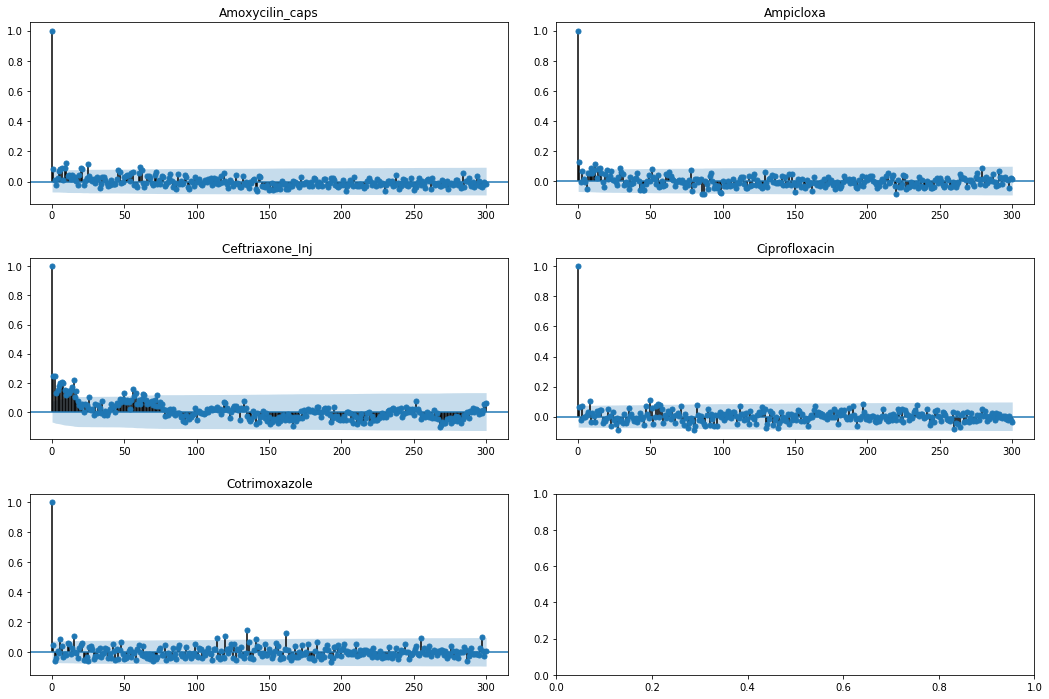

In [0]:
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=3
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(18,12))
    for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_acf(df[x], lags=300, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

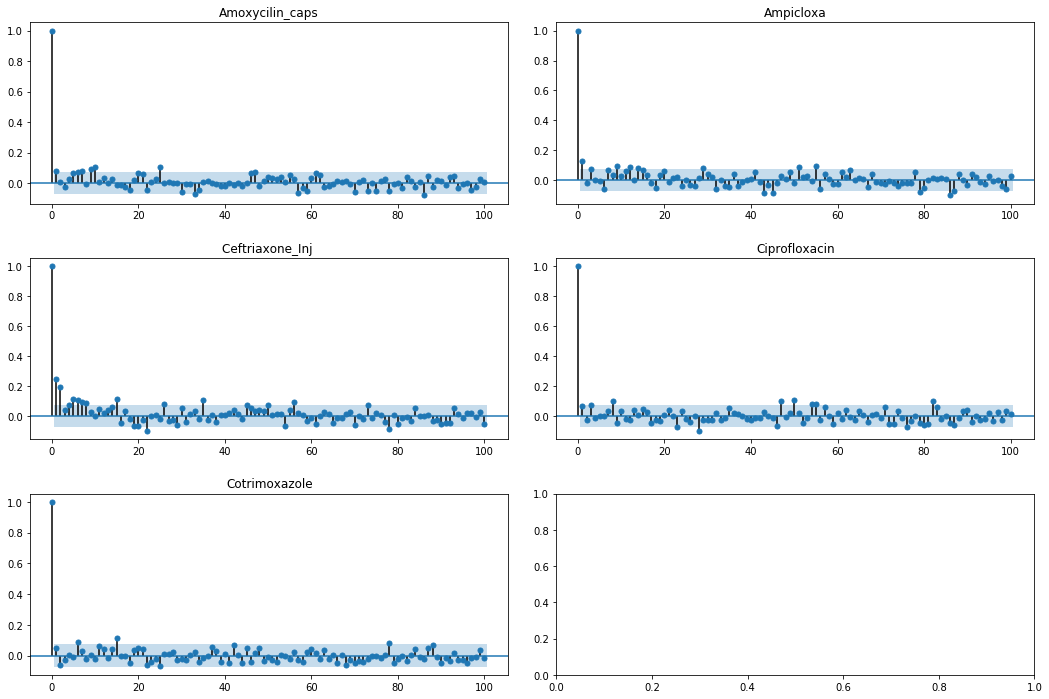

In [0]:
from statsmodels.graphics.tsaplots import plot_pacf
from statsmodels.graphics.tsaplots import plot_acf

subplotindex=0
numrows=3
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,12))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
with plt.rc_context():
    plt.rc("figure", figsize=(14,6))
    for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
        rowindex=math.floor(subplotindex/numcols)
        colindex=subplotindex-(rowindex*numcols)
        plot_pacf(df[x], lags=100, title=x, ax=ax[rowindex,colindex])
        subplotindex=subplotindex+1

In [0]:
resultsRolling={'Amoxycilin_caps':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ampicloxa':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ceftriaxone_Inj ':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ciprofloxacin':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Cotrimoxazole':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsRollingdf = pd.DataFrame(resultsRolling)
resultsRollingdf.index = ['Naive MSE', 'Naive MAPE', 'Seasonal Naive MSE', 'Seasonal Naive MAPE', 
                          'ARIMA MSE', 'ARIMA MAPE', 'AutoARIMA MSE', 'AutoARIMA MAPE',
                         'Prophet MSE', 'Prophet MAPE']
resultsLongterm={'Amoxycilin_caps':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ampicloxa':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ceftriaxone_Inj ':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Ciprofloxacin':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0],
     'Cotrimoxazole':[0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0]}
resultsLongtermdf = pd.DataFrame(resultsLongterm)
resultsLongtermdf.index = ['Average MSE', 'Average MAPE', 'ARIMA MSE', 'ARIMA MAPE', 
                           'AutoARIMA MSE', 'AutoARIMA MAPE', 'Prophet MSE', 'Prophet MAPE',
                          'Vanilla LSTM MSE', 'Vanilla LSTM MAPE', 'Stacked LSTM MSE', 'Stacked LSTM MAPE',
                          'Bidirectional LSTM MSE', 'Bidirectional LSTM MAPE']

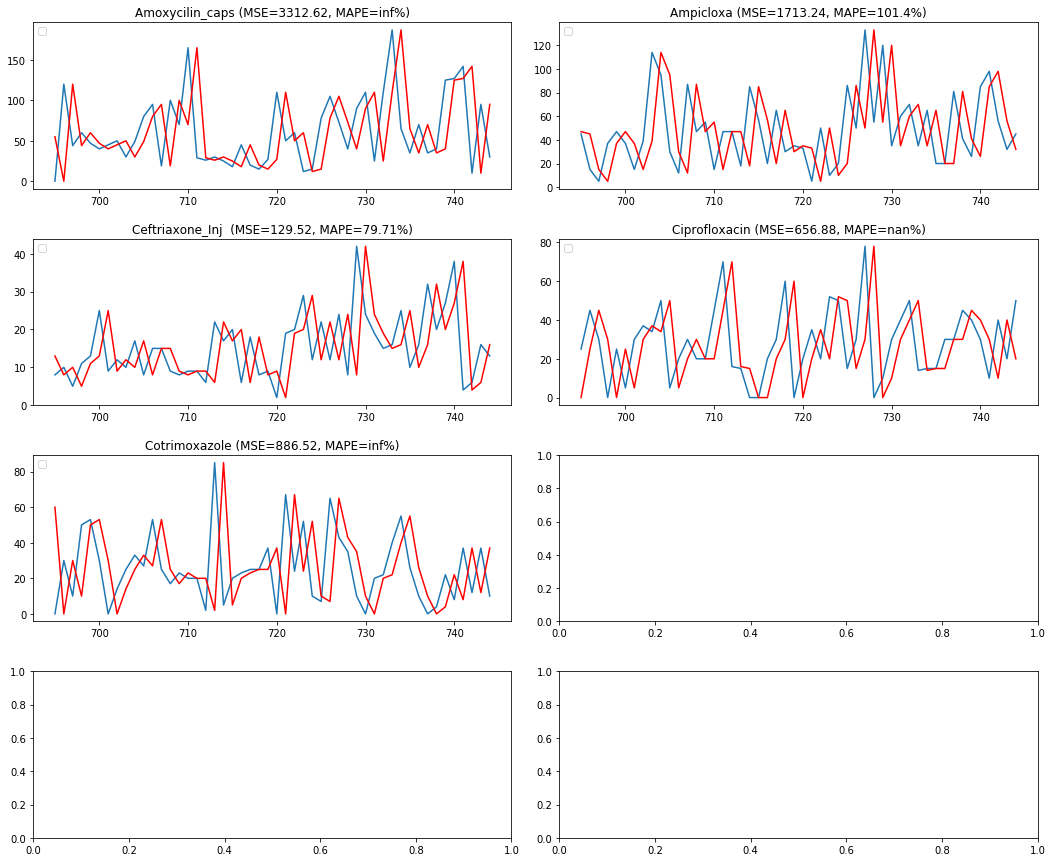

In [0]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    ds=df[x]
    dataframe = concat([ds.shift(1), ds], axis=1)
    dataframe.columns = ['t+1', 't-1']
    size = len(dataframe)-50
    X=dataframe['t-1']
    Y=dataframe['t+1']
    test, predictions = X[size:len(X)], Y[size:len(Y)]
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Naive MSE',x]=error
    resultsRollingdf.loc['Naive MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

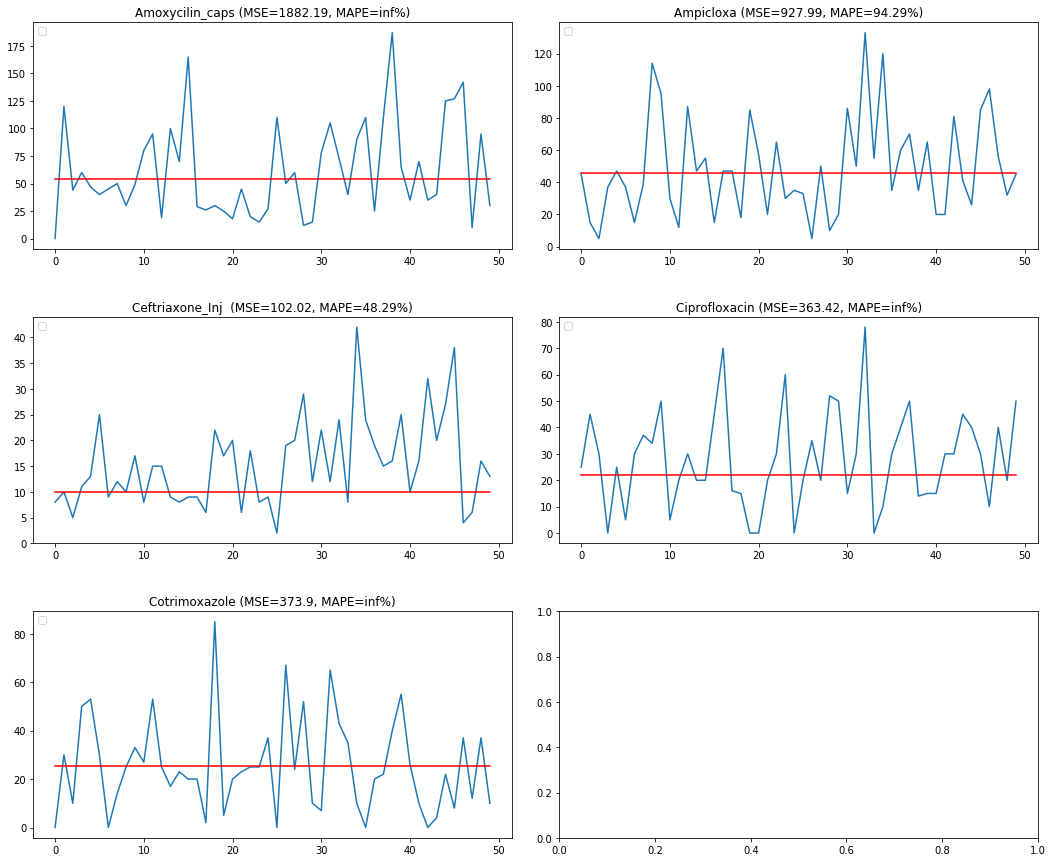

In [0]:
subplotindex=0
numrows=3
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-50
    test = X[size:len(X)] 
    mean = np.mean(X[0:size])
    predictions = np.full(50,mean)
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsLongtermdf.loc['Average MSE',x]=error
    resultsLongtermdf.loc['Average MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

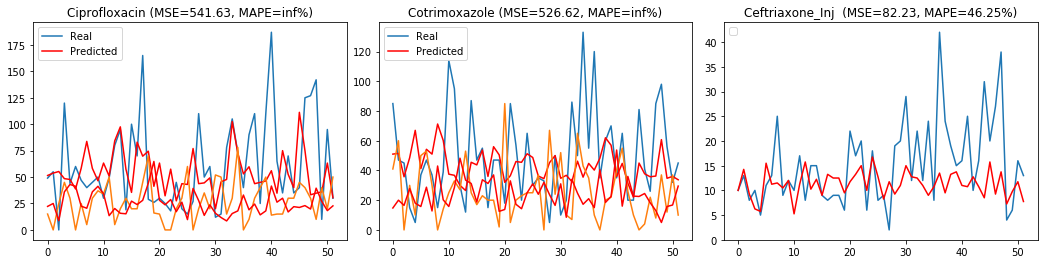

In [0]:
subplotindex=0
numrows=1
numcols=3
fig, ax = plt.subplots(numrows, numcols, figsize=(18,4))
plt.subplots_adjust(wspace=0.1, hspace=0.3)
for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    size = len(X)-52
    test = X[size:len(X)]
    train = X[0:size]
    predictions=list()
    history = [x for x in train]
    for i in range(len(test)):
        obs=list()
        for y in range(1,5):
            obs.append(train[-(y*52)+i])
        yhat = np.mean(obs)
        predictions.append(yhat)
        history.append(test[i])
    error = mean_squared_error(test, predictions)
    perror = mean_absolute_percentage_error(test, predictions)
    resultsRollingdf.loc['Seasonal Naive MSE',x]=error
    resultsRollingdf.loc['Seasonal Naive MAPE',x]=perror
    ax[colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[colindex].plot(test)
    ax[colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()    

In [0]:
import statsmodels.api as sm
df=pd.read_excel(os.path.join("Excel","more_sales.xlsx"))
warnings.filterwarnings("ignore")
for x in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    resDiff = sm.tsa.arma_order_select_ic(df[x], max_ar=5, max_ma=5, ic='aic', trend='c')
    print('ARMA(p,q,'+x+') =',resDiff['aic_min_order'],'is the best.')

ARMA(p,q,Amoxycilin_caps) = (4, 2) is the best.
ARMA(p,q,Ampicloxa) = (2, 2) is the best.
ARMA(p,q,Ceftriaxone_Inj ) = (5, 4) is the best.
ARMA(p,q,Ciprofloxacin) = (4, 4) is the best.
ARMA(p,q,Cotrimoxazole) = (2, 2) is the best.


# The computing intense Section

In [0]:
df=pd.read_excel(os.path.join("Excel","more_sales.xlsx"))
def evaluate_arima_model(X, arima_order):
    train_size = int(len(X) * 0.66)
    train, test = X[0:train_size], X[train_size:]
    history = [x for x in train]
    predictions = list()
    for t in range(len(test)):
        model = ARIMA(history, order=arima_order)
        model_fit = model.fit(disp=0)
        yhat = model_fit.forecast()[0]
        predictions.append(yhat)
        history.append(test[t])
    error = mean_squared_error(test, predictions)
    return error

def evaluate_models(f, dataset, p_values, d_values, q_values):
    best_score, best_cfg = float("inf"), None
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = (p,d,q)
                try:
                    mse = evaluate_arima_model(dataset, order)
                    if mse < best_score:
                        best_score, best_cfg = mse, order
                except:
                    continue
    print(f+' - Best ARIMA%s MSE=%.3f' % (best_cfg, best_score))

p_values = range(0, 6)
d_values = range(0, 2)
q_values = range(0, 6)

warnings.filterwarnings("ignore")

#df=pd.read_csv('../input/salesweekly.csv')

for f in ['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']:
    evaluate_models(f, df[f].values, p_values, d_values, q_values)

# Recurrent Neural network

In [2]:
!pip3 uninstall tensorflow==1.15.0

Uninstalling tensorflow-2.0.0:
  Would remove:
    /usr/local/bin/saved_model_cli
    /usr/local/bin/tensorboard
    /usr/local/bin/tf_upgrade_v2
    /usr/local/bin/tflite_convert
    /usr/local/bin/toco
    /usr/local/bin/toco_from_protos
    /usr/local/lib/python3.6/dist-packages/tensorflow-2.0.0.dist-info/*
    /usr/local/lib/python3.6/dist-packages/tensorflow/*
    /usr/local/lib/python3.6/dist-packages/tensorflow_core/*
Proceed (y/n)? n


In [4]:
!pip3 install keras==2.3.0

     |████████████████████████████████| 378kB 8.7MB/s 
  Found existing installation: Keras 2.2.5
    Uninstalling Keras-2.2.5:
      Successfully uninstalled Keras-2.2.5


In [5]:
import keras
keras.__version__

Using TensorFlow backend.


'2.3.0'

In [0]:
import tensorflow as tf
import random
seed_value= 0
import os
os.environ['PYTHONHASHSEED']=str(seed_value)
import random
random.seed(seed_value)
import numpy as np
np.random.seed(seed_value)
import tensorflow as tf
tf.random.set_seed(seed_value)

session_conf = tf.compat.v1.ConfigProto(intra_op_parallelism_threads=1, inter_op_parallelism_threads=1)
sess = tf.compat.v1.Session(graph=tf.compat.v1.get_default_graph(), config=session_conf)
tf.compat.v1.keras.backend.set_session(sess)

In [0]:
df=pd.read_excel(os.path.join("Excel","more_sales.xlsx"))
from keras.models import Sequential
from keras.layers import LSTM
from keras.layers import Dense
from keras.layers import Bidirectional
from sklearn.preprocessing import MinMaxScaler

def split_sequence(sequence, n_steps):
    X, y = list(), list()
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence)-1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return array(X), array(y)

size = int(len(df) - 50)
n_steps=5
n_features = 1

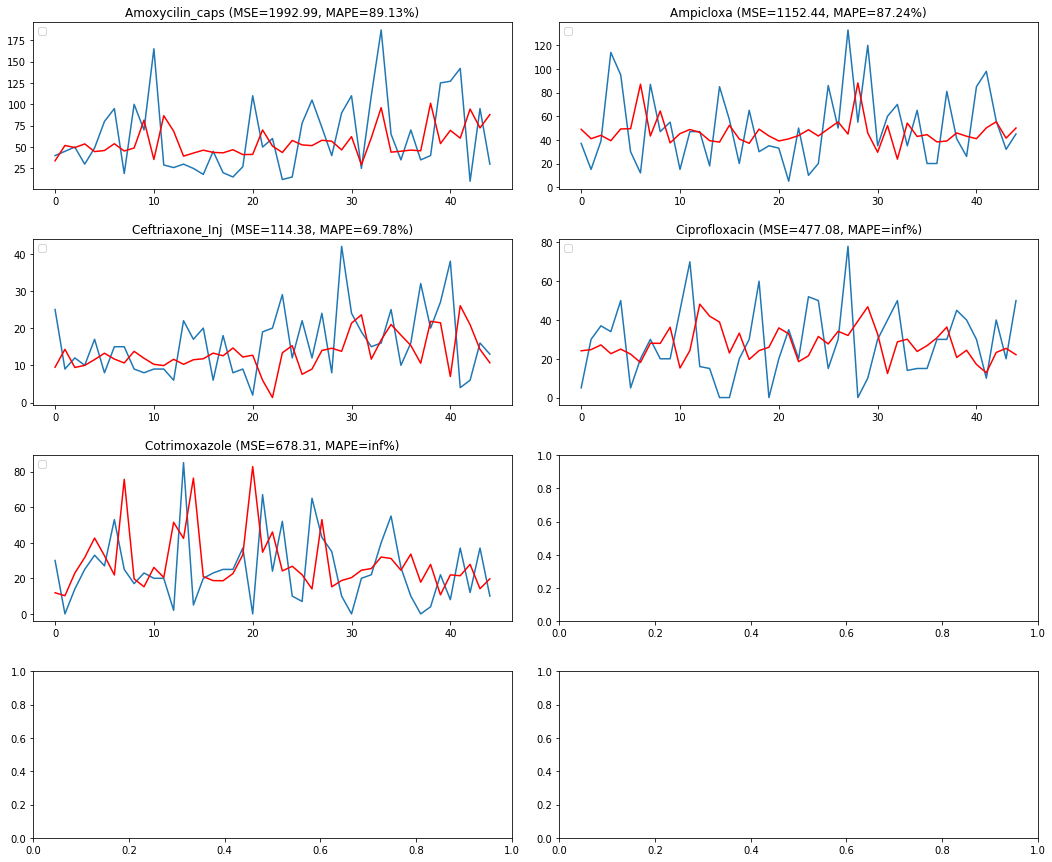

In [10]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    model = Sequential()
    model.add(LSTM(100, activation='relu', input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Vanilla LSTM MSE',x]=error
    resultsLongtermdf.loc['Vanilla LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

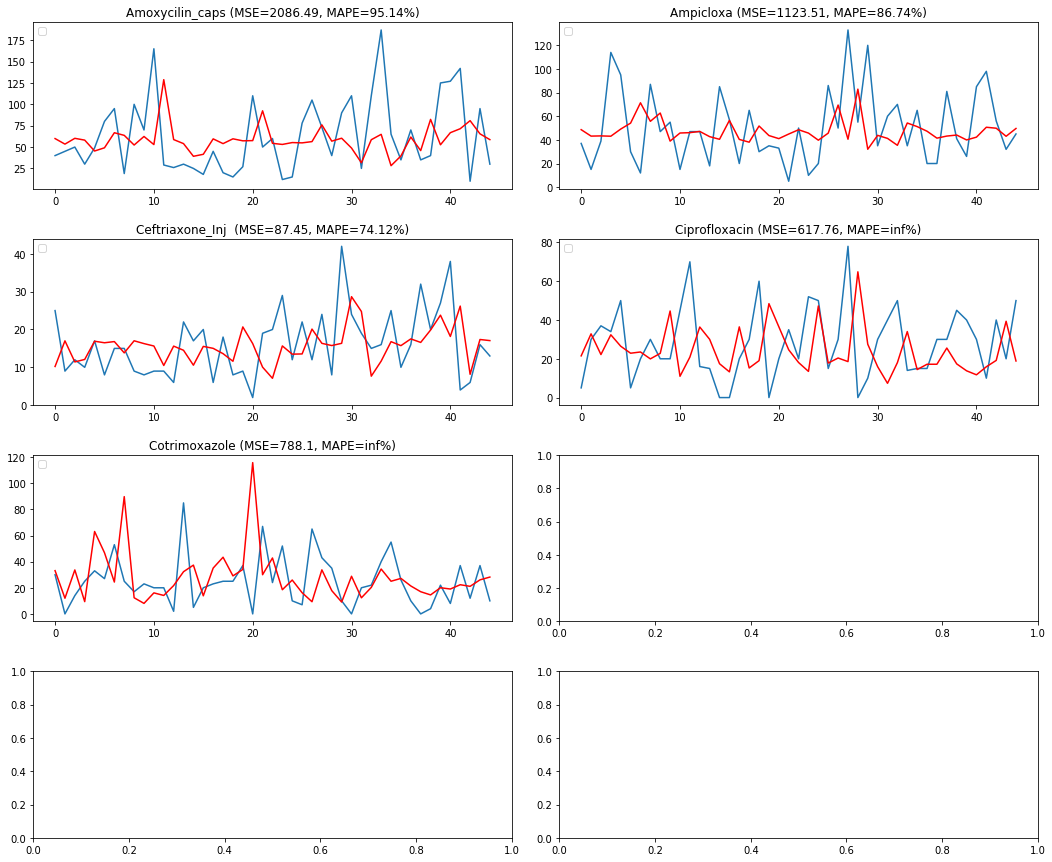

In [11]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))
    
    model = Sequential()
    model.add(LSTM(100, activation='relu', return_sequences=True, input_shape=(n_steps, n_features)))
    model.add(LSTM(100, activation='relu'))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)
    
    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Stacked LSTM MSE',x]=error
    resultsLongtermdf.loc['Stacked LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()

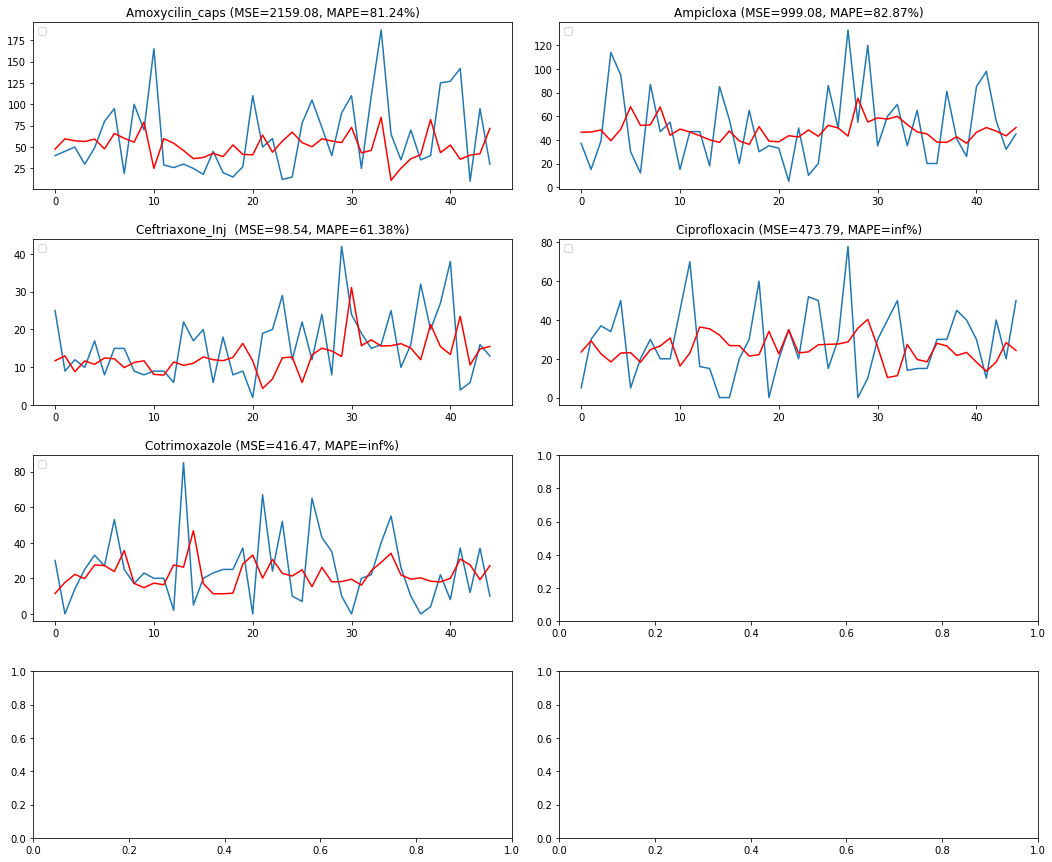

In [13]:
subplotindex=0
numrows=4
numcols=2
fig, ax = plt.subplots(numrows, numcols, figsize=(18,15))
plt.subplots_adjust(wspace=0.1, hspace=0.3)

warnings.filterwarnings("ignore")

r=['Amoxycilin_caps','Ampicloxa','Ceftriaxone_Inj ','Ciprofloxacin','Cotrimoxazole']
for x in r:
    rowindex=math.floor(subplotindex/numcols)
    colindex=subplotindex-(rowindex*numcols)
    X=df[x].values
    scaler = MinMaxScaler(feature_range = (0, 1))
    X=scaler.fit_transform(X.reshape(-1, 1))
    X_train,y_train=split_sequence(X[0:size], n_steps)
    X_test,y_test=split_sequence(X[size:len(df)], n_steps)
    X_train = X_train.reshape((X_train.shape[0], X_train.shape[1], n_features))

    model = Sequential()
    model.add(Bidirectional(LSTM(50, activation='relu'), input_shape=(n_steps, n_features)))
    model.add(Dense(1))
    model.compile(optimizer='adam', loss='mse')
    model.fit(X_train, y_train, epochs=400, verbose=0)

    X_test = X_test.reshape((len(X_test), n_steps, n_features))
    predictions = model.predict(X_test, verbose=0)
    y_test=scaler.inverse_transform(y_test)
    predictions = scaler.inverse_transform(predictions)
    error = mean_squared_error(y_test, predictions)
    perror = mean_absolute_percentage_error(y_test, predictions)
    resultsLongtermdf.loc['Bidirectional LSTM MSE',x]=error
    resultsLongtermdf.loc['Bidirectional LSTM MAPE',x]=perror
    ax[rowindex,colindex].set_title(x+' (MSE=' + str(round(error,2))+', MAPE='+ str(round(perror,2)) +'%)')
    ax[rowindex,colindex].legend(['Real', 'Predicted'], loc='upper left')
    ax[rowindex,colindex].plot(y_test)
    ax[rowindex,colindex].plot(predictions, color='red')
    subplotindex=subplotindex+1
plt.show()


In [14]:
from IPython.display import display, HTML
display(HTML(resultsLongtermdf.to_html()))

,Amoxycilin_caps,Ampicloxa,Ceftriaxone_Inj,Ciprofloxacin,Cotrimoxazole
Average MSE,0.000000,0.000000,0.000000,0.000000,0.000000
Average MAPE,0.000000,0.000000,0.000000,0.000000,0.000000
ARIMA MSE,0.000000,0.000000,0.000000,0.000000,0.000000
ARIMA MAPE,0.000000,0.000000,0.000000,0.000000,0.000000
AutoARIMA MSE,0.000000,0.000000,0.000000,0.000000,0.000000
AutoARIMA MAPE,0.000000,0.000000,0.000000,0.000000,0.000000
Prophet MSE,0.000000,0.000000,0.000000,0.000000,0.000000
Prophet MAPE,0.000000,0.000000,0.000000,0.000000,0.000000
Vanilla LSTM MSE,1992.988497,1152.440552,114.375701,477.080848,678.311004
Vanilla LSTM MAPE,89.127919,87.236741,69.777434,inf,inf
